In [7]:
import numpy as np; print('numpy:', np.__version__)
import scipy as sp; print('scipy:', sp.__version__)
from scipy import fftpack

#import matplotlib; matplotlib.use('Agg')
%matplotlib inline
import matplotlib as mpl; print('matplotlib:', mpl.__version__)
from matplotlib import pyplot as plt

plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = plt.rcParams['axes.linewidth']
plt.rcParams['ytick.major.width'] = plt.rcParams['axes.linewidth']
plt.rcParams['figure.figsize'] = (5.8, 4.1)
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.size'] = 12

import itertools

numpy: 1.22.3
scipy: 1.8.0
matplotlib: 3.5.1


In [8]:
#from pyconf import nx, ny, nout as ii, ioprune
#nx = nx//ioprune
#ny = ny//ioprune
#prefix = 'io/nature/ens0000/'
#prefix = 'io/observed/ens0000/'
prefix = 'io/calc/ens0000/'
def ifilename(t, v, prefix=prefix):
    return prefix + '/' + v + '_step' + ('%010d'%t) + '.dat'

#print(f'nx = {nx}, ny = {ny}, nout = {ii}')
nx = 256
ny = nx
dtype = np.float32
u0_factor = 1

loading: 2000 / 2000


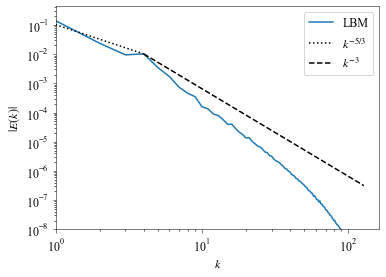

[4.63223486e-08 1.31206428e-01 4.14803121e-02 1.47768745e-02]
R(kf): 0.8985759073891305
.

In [6]:
# energy spectrum

def get_fft(t):
    #with open(ifilename(t, 'rho')) as f:
    #    rho = np.fromfile(f, dtype=dtype, sep='').reshape(ny, nx)
    with open(ifilename(t, 'u')) as f:
        u = u0_factor * np.fromfile(f, dtype=dtype, sep='').reshape(ny, nx)
    with open(ifilename(t, 'v')) as f:
        v = u0_factor * np.fromfile(f, dtype=dtype, sep='').reshape(ny, nx)
    
    kmax = nx//2
    krange = np.arange(kmax + 1)
    ek = np.zeros(len(krange))
    
    #fft = fftpack.fftn((u**2 + v**2)/2) / nx / ny
    fftu = fftpack.fftn(u) / nx / ny
    fftv = fftpack.fftn(v) / nx / ny
    fft = (fftu**2 + fftv**2)/2
    
    for i,j in itertools.product(krange, krange):
        k = int(np.sqrt(i**2 + j**2) + 0.5)
        #print(i, j, k)
        if k <= kmax:
            ek[k] += np.abs(fft[i,j])
            
    return krange, ek
    
def plot(k, ek,):   
    fig, ax = plt.subplots()
    ax.plot(k, ek, label='LBM')
    
    # tmp log theory
    kf = 4
    k0, k1 = 1, nx//2
    e = ek[kf]
    s = 1
    b = 1
    
    kp = -5/3
    n = np.array([(kf/k0)**-kp, 1])*b
    ax.plot([k0, kf], e*s*n, label=r'$k^{-5/3}$', color='k', ls=':')
    #ax.plot([k0, kf], e/s*n, color='k', ls=':')
    
    kp = -3
    n = np.array([1, (k1/kf)**kp])*b
    ax.plot([kf, k1], e*s*n, label=r'$k^{-3}$', color='k', ls='--')
    #ax.plot([kf, k1], e/s*n, color='k', ls='--')
        
    # finalize
    ax.legend()
    ax.set_xlabel(r'$k$')
    ax.set_ylabel(r'$|E(k)|$')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1,)
    ax.set_ylim(1e-8,)
    
    fig.savefig('fourier.pdf', bbox_inches='tight')
    
    plt.show(fig)
    plt.close(fig)
    
def sub():
    ekas = []
    for i in range(1000, 2010, 10):
        print(f'\rloading: {i:4d} / 2000', end='', flush=True)
        k, ek = get_fft(i)
        ekas.append(np.abs(ek))
    print()
    plot(k, np.mean(ekas, axis=0))
    
    # energy contribution ratio
    kf = 4
    print(ek[:kf])
    ec = np.sum(ek[:kf])
    et = np.sum(ek)
    print('R(kf):', ec/et)
        
    print(end='.', flush=True)
    
sub()

In [ ]:
# fft prefixes

def get_fft_prefix(prefix, t):
    #with open(ifilename(t, 'rho')) as f:
    #    rho = np.fromfile(f, dtype=dtype, sep='').reshape(ny, nx)
    with open(ifilename(t, 'u', prefix=prefix)) as f:
        u = u0_factor * np.fromfile(f, dtype=dtype, sep='').reshape(ny, nx)
    with open(ifilename(t, 'v', prefix=prefix)) as f:
        v = u0_factor * np.fromfile(f, dtype=dtype, sep='').reshape(ny, nx)
    
    kmax = nx//2
    krange = np.arange(kmax + 1)
    ek = np.zeros(len(krange))
    
    #fft = fftpack.fftn((u**2 + v**2)/2) / nx / ny
    fftu = fftpack.fftn(u) / nx / ny
    fftv = fftpack.fftn(v) / nx / ny
    fft = (fftu**2 + fftv**2)/2
    
    for i,j in itertools.product(krange, krange):
        k = int(np.sqrt(i**2 + j**2) + 0.5)
        #print(i, j, k)
        if k <= kmax:
            ek[k] += np.abs(fft[i,j])
            
    return krange, ek
    
def plots(prefixes, labels):   
    fig, ax = plt.subplots()
    
    for prefix, label in zip(prefixes, labels):
        ekas = []
        for i in range(1000, 2010, 10):
            print(f'\rloading: {i:4d} / 2000', end='', flush=True)
            k, ek = get_fft_prefix(prefix, i)
            ekas.append(np.abs(ek))
        print()
        ax.plot(k, np.mean(ekas, axis=0), label=label)
    
    # plots log law
    kf = 8
    k0, k1 = 1, nx//2
    e = ek[kf]
    s = 1
    b = 1
    
    kp = -5/3
    n = np.array([(kf/k0)**-kp, 1])*b
    ax.plot([k0, kf], e*s*n, label=r'$k^{-5/3}$', color='k', ls=':')
    #ax.plot([k0, kf], e/s*n, color='k', ls=':')
    
    kp = -3
    n = np.array([1, (k1/kf)**kp])*b
    ax.plot([kf, k1], e*s*n, label=r'$k^{-3}$', color='k', ls='--')
    #ax.plot([kf, k1], e/s*n, color='k', ls='--')
        
    # finalize
    ax.legend()
    ax.set_xlabel(r'$k$')
    ax.set_ylabel(r'$|E(k)|$')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1,)
    ax.set_ylim(1e-8,)
    
    fig.savefig('fourier.pdf', bbox_inches='tight')
    
    plt.show(fig)
    plt.close(fig)

p0 = 'result/1208_fourier'
plots(
    [f'{p0}/ssm_nu0', f'{p0}/ssm_nu1em4',    f'{p0}/csm_nu0', f'{p0}/csm_nu1em4', ],
    [r'SSM, $\nu=0$', r'SSM, $\nu=10^{-4}$', r'CSM, $\nu=0$', r'CSM, $\nu=10^{-4}$', ]
)

t = 2000


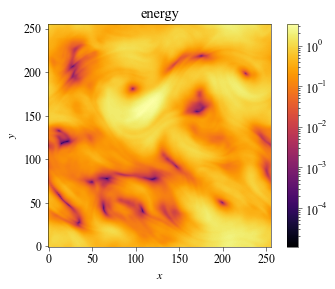

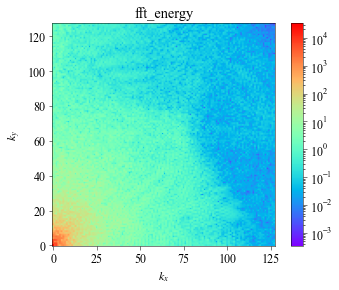

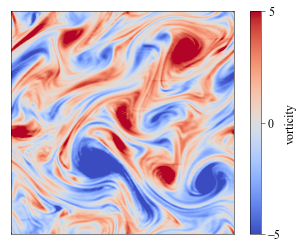

.

In [15]:
# energy

def plot(tt, show_mpl=True, v2=None):
    for t in tt:
        print(f't = {t}')
        with open(ifilename(t, 'u')) as f:
            u = np.fromfile(f, dtype=dtype, sep='').reshape(ny, nx)
        with open(ifilename(t, 'v')) as f:
            v = np.fromfile(f, dtype=dtype, sep='').reshape(ny, nx)
        with open(ifilename(t, 'vor')) as f:
            vor = np.fromfile(f, dtype=dtype, sep='').reshape(ny, nx)
            
        energy = 1/2 * (u**2 + v**2)
        enstrophy = 1/2 * (vor**2)
        es = np.abs(fftpack.fftn(energy))
        et = np.abs(fftpack.fftn(enstrophy))
        
        for i, j in itertools.product(range(nx), range(ny)):
            es[i, j] = max(1e-30, es[i, j])
            et[i, j] = max(1e-30, et[i, j])
    
        ## heatmap
        if show_mpl:
            (fig, ax) = plt.subplots()
            pc = ax.imshow(energy, cmap='inferno', norm=mpl.colors.LogNorm())
            plt.colorbar(pc)
            ax.invert_yaxis()
            ax.set_title('energy')
            ax.set_xlabel(r'$x$')
            ax.set_ylabel(r'$y$')
            plt.show()
            plt.close(fig)
    
            (fig, ax) = plt.subplots()
            pc = ax.imshow(es[:nx//2,:nx//2], cmap='rainbow', norm=mpl.colors.LogNorm())
            plt.colorbar(pc)
            ax.invert_yaxis()
            #ax.set_xscale('log')
            #ax.set_yscale('log')
            #ax.set_xlim(1,nx//2)
            #ax.set_ylim(1,ny//2)
            ax.set_xlabel(r'$k_x$')
            ax.set_ylabel(r'$k_y$')
            ax.set_title('fft_energy')
            plt.show()
            plt.close(fig)
            
            #(fig, ax) = plt.subplots()
            #pc = ax.imshow(enstrophy, cmap='inferno', norm=mpl.colors.LogNorm())
            #plt.colorbar(pc)
            #ax.invert_yaxis()
            #ax.set_title('enstrophy')
            #plt.show()
            #plt.close(fig)
            
            #(fig, ax) = plt.subplots()
            #pc = ax.imshow(es[:nx//2,:nx//2], cmap='RdBu_r')
            #plt.colorbar(pc)
            #ax.invert_yaxis()
            #ax.set_title('fft_enstrophy')
            #plt.show()
            #plt.close(fig)
            
            (fig, ax) = plt.subplots()
            v = 5
            pc = ax.imshow(vor, cmap='coolwarm', vmin=-v, vmax=v)
            #pc = ax.contour(vor, [-20, 20], cmap='coolwarm', linewidths=1)
            plt.colorbar(pc, label='vorticity', ticks=[-v,0,v])
            #ax.invert_yaxis()
            #ax.set_xlabel(r'$x$')
            #ax.set_ylabel(r'$y$')
            #ax.set_title('vorticity')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_aspect('equal')
            fig.savefig(f'nature_vorticity_step{t}.pdf', bbox_inches='tight')
            plt.show()
            plt.close(fig)


        
#plot(range(0, 20000, 1000))
plot([2000,])

print(end='.', flush=True)

FileNotFoundError: [Errno 2] No such file or directory: 'io/calc/0/vor_step2000.dat'

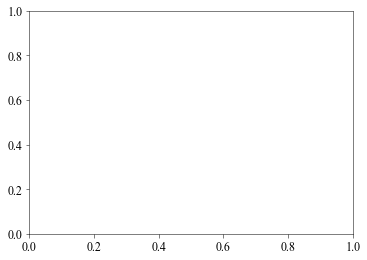

In [5]:
# spagetti

def plot_spa(t):
    (fig, ax) = plt.subplots()
    prefixc = lambda k: f'io/calc/{k}'
    for k in range(64):
        with open(ifilename(t, 'vor', prefix=prefixc(k))) as f:
            vor = np.fromfile(f, dtype=dtype, sep='').reshape(ny, nx)
            ax.contour(vor, [-20, 20], cmap='coolwarm', linewidths=1, alpha=0.1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    fig.savefig('vor_spa.pdf', bbox_inches='tight')
    plt.show()
    plt.close(fig)
    
plot_spa(2000)